In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage
import math
import time
from math import log10, sqrt 

print("numpy version : {}".format(np.__version__))
print("tensorflow version : {}".format(tf.__version__))

ModuleNotFoundError: No module named 'tensorflow'

## Define a Simple Neural Implicit Function 

### Prepareing Data

In [115]:
#Image = skimage.data.camera()
#Image = plt.imread("data/KODAK/15.png")

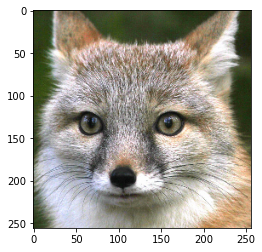

In [151]:
# for "1.jpg" image
Image = plt.imread("1.jpg")
c = [Image.shape[0]//2, Image.shape[1]//2]
r = 256
Image = Image[c[0]-r:c[0]+r, c[1]-r:c[1]+r]
Image = Image[::2,::2] / 255.
plt.imshow(Image)

In [152]:
Image = Image.astype(np.float32)
#Image = Image.astype(np.float32)[:256, :256, :]

In [153]:
#Image = Image / 255

In [154]:
def make_coordiante(shape):
    x_coordinates = np.linspace(-1, +1, shape[0])
    y_coordinates = np.linspace(-1, +1, shape[1])
    x_coordinates, y_coordinates = np.meshgrid(x_coordinates, y_coordinates)
    x_coordinates = x_coordinates.flatten()
    y_coordinates = y_coordinates.flatten()
    Coordinates = np.stack([x_coordinates, y_coordinates]).T
    return Coordinates

In [155]:
Coordinates = make_coordiante(Image.shape)

In [121]:
#RGB_values = Image.flatten()
RGB_values = np.array([Image[:,:,color].flatten() for color in range(3)]).T

In [156]:
n_fourier_features = 10
scale = 10

In [122]:
# Add fourier Features if u want to use Non-trainable fourier feature run this cell

B = np.random.randn(2, n_fourier_features)
B = scale * B

Coordinates = Coordinates @ B
Coordinates = np.concatenate([np.sin(2 * math.pi * Coordinates), np.cos(2 * math.pi * Coordinates)], axis=-1)
Coordinates.shape

(65536, 20)

### Build Model

#### Sine Layer

In [9]:
class SineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(SineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    
    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / self.in_features,
                                                       maxval= 1 / self.in_features)
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
    

    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = tf.sin(self.omega_0 * befor_activation)
        return after_activation

#### Parametric

In [10]:
class ParaSineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(ParaSineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    
    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / self.in_features,
                                                       maxval= 1 / self.in_features)
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
    

    def build(self, input_shape):

        self.a_1 = self.add_weight(
            name='a_1',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a0 = self.add_weight(
            name='a0',
            shape=(1,),
            initializer='ones',
            trainable=True)

        self.a1 = self.add_weight(
            name='a1',
            shape=(1,),
            initializer='zeros',
            trainable=True)
        self.w1 = self.add_weight(
            name='w1',
            shape=(1,),
            initializer='uniform',
            trainable=True)

        self.a2 = self.add_weight(
            name='a2',
            shape=(1,),
            initializer='zeros',
            trainable=True)
        self.w2 = self.add_weight(
            name='w2',
            shape=(1,),
            initializer='uniform',
            trainable=True)

        self.a3 = self.add_weight(
            name='a3',
            shape=(1,),
            initializer='zeros',
            trainable=True)
        self.w3 = self.add_weight(
            name='w3',
            shape=(1,),
            initializer='uniform',
            trainable=True)

        super(ParaSineLayer, self).build(input_shape)


    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = self.a_1 * self.omega_0 * befor_activation + \
                           self.a0 * tf.cos(self.omega_0 * befor_activation) + \
                           self.a1 * tf.cos(self.w1 * self.omega_0 * befor_activation) + \
                           self.a2 * tf.cos(self.w2 * self.omega_0 * befor_activation) + \
                           self.a3 * tf.cos(self.w3 * self.omega_0 * befor_activation)
        return after_activation

In [158]:
class ParaSineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(ParaSineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    
    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / self.in_features,
                                                       maxval= 1 / self.in_features)
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
    

    def build(self, input_shape):

        self.a_1 = self.add_weight(
            name='a_1',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a0 = self.add_weight(
            name='a0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w0 = self.add_weight(
            name='w0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift0 = self.add_weight(
            name='shift0',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a1 = self.add_weight(
            name='a1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w1 = self.add_weight(
            name='w1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift1 = self.add_weight(
            name='shift1',
            shape=(1,),
            initializer='zeros',
            trainable=True)


        super(ParaSineLayer, self).build(input_shape)


    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = self.a_1 * self.omega_0 * befor_activation + \
                           self.a0 * tf.sin(self.w0 * self.omega_0 * befor_activation + self.shift0) + \
                           self.a1 * tf.cos(self.w1 * self.omega_0 * befor_activation + self.shift1)
        return after_activation

In [82]:
class ParaSineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False):
        super(ParaSineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    
    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomNormal(stddev=10)
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features),
                                                       maxval= np.sqrt(6. / self.in_features))
    

    def build(self, input_shape):

        self.a_1 = self.add_weight(
            name='a_1',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a0 = self.add_weight(
            name='a0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w0 = self.add_weight(
            name='w0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift0 = self.add_weight(
            name='shift0',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a1 = self.add_weight(
            name='a1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w1 = self.add_weight(
            name='w1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift1 = self.add_weight(
            name='shift1',
            shape=(1,),
            initializer='zeros',
            trainable=True)


        super(ParaSineLayer, self).build(input_shape)


    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = self.a_1 * befor_activation + \
                           self.a0 * tf.sin(self.w0 * befor_activation + self.shift0) + \
                           self.a1 * tf.cos(self.w1 * befor_activation + self.shift1)
        return after_activation

In [159]:
class FourierLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, n_features, scale=10):
        super(FourierLayer, self).__init__()
        self.in_features = in_features
        self.n_features = n_features
        self.scale = scale

        self.dense = tf.keras.layers.Dense(self.n_features,
                                           use_bias=False,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    
    def init_weights(self):
        return tf.keras.initializers.RandomNormal(stddev=self.scale)
    

    def build(self, input_shape):
        self.a0 = self.add_weight(
            name='a0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.a1 = self.add_weight(
            name='a1',
            shape=(1,),
            initializer='ones',
            trainable=True)

        super(FourierLayer, self).build(input_shape)


    def call(self, input_tensor):
        befor_sinecosine = self.dense(input_tensor)
        after_sinecosine = tf.concat([self.a0 * tf.sin(befor_sinecosine ),
                                      self.a1 * tf.cos(befor_sinecosine)] , axis=-1)
        return after_sinecosine

In [220]:
class FourierLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, n_features, scale=10):
        super(FourierLayer, self).__init__()
        self.in_features = in_features
        self.n_features = n_features
        self.scale = scale

        self.dense = tf.keras.layers.Dense(self.n_features,
                                           use_bias=False,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    
    def init_weights(self):
        return tf.keras.initializers.RandomNormal(stddev=1)


    def call(self, input_tensor):
        befor_sinecosine = self.scale * self.dense(input_tensor)
        after_sinecosine = tf.concat([tf.sin(befor_sinecosine),
                                      tf.cos(befor_sinecosine)] , axis=-1)
        return after_sinecosine

#### SIREN

In [48]:
class Siren(tf.keras.Model):
    def __init__(self, in_features,
                    units,
                    out_features,
                    outermost_linear=True,
                    first_omega_0=30.,
                    hidden_omega_0=30.):
        super(Siren, self).__init__()
        self.in_features = in_features
        self.units = units
        self.out_features = out_features
        self.outermost_linear = outermost_linear
        self.first_omega_0 = first_omega_0
        self.hidden_omega_0 = hidden_omega_0


        self.net = []

        self.net.append(SineLayer(self.in_features,
                                  self.units[0],
                                  is_first=True,
                                  omega_0=self.first_omega_0))

        for counter in range(1, len(units)):
            self.net.append(SineLayer(self.units[counter-1],
                                      self.units[counter], 
                                      is_first=False,
                                      omega_0=self.hidden_omega_0))

        if self.outermost_linear:
            self.net.append(tf.keras.layers.Dense(self.out_features,
                                                  kernel_initializer=self.init_weights()))
        else:
            self.net.append(SineLayer(self.units[counter],
                                      self.out_features,
                                      is_first=False,
                                      omega_0=self.hidden_omega_0))


    def init_weights(self):
        return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.units[-1]) / self.hidden_omega_0,
                                                   maxval= np.sqrt(6. / self.units[-1]) / self.hidden_omega_0)



    def call(self, input_tensor):
        x = input_tensor
        for layer in self.net:
            x = layer(x)
        
        return x

In [221]:
class CustomSaver(tf.keras.callbacks.Callback):
    def __init__(self, image_shape):
        super(CustomSaver, self).__init__()
        self.image_shape = image_shape
        self.data = tf.data.Dataset.from_tensor_slices(make_coordiante(self.image_shape)).batch(2048)
        self.images = []
    def on_epoch_end(self, epoch, logs={}):
        self.images.append(self.model.predict(self.data).reshape(self.image_shape))

save_result_siren = CustomSaver(Image.shape)
save_result_param = CustomSaver(Image.shape)
save_result_fourier = CustomSaver(Image.shape)

In [222]:
hidden_units = 256

In [223]:
input_initializers = tf.keras.initializers.RandomUniform(minval=-1/2, maxval=1/2)
hidden_initializers = tf.keras.initializers.RandomUniform(minval=-np.sqrt(6/hidden_units)/30, maxval=np.sqrt(6/hidden_units)/30)

In [262]:
## SIREN Model
X = tf.keras.layers.Input(shape=(2,))
x = SineLayer(2, hidden_units, is_first=True)(X)
x = SineLayer(hidden_units, hidden_units, is_first=False)(x)
x = SineLayer(hidden_units, hidden_units, is_first=False)(x)
x = SineLayer(hidden_units, hidden_units, is_first=False)(x)

Y = tf.keras.layers.Dense(3, kernel_initializer=hidden_initializers)(x)

model = tf.keras.models.Model(X, Y)

In [273]:
## Parametric Model
X = tf.keras.layers.Input(shape=(2,))
x = ParaSineLayer(2, hidden_units, is_first=True)(X)
x = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x)
x = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x)
x = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x)

Y = tf.keras.layers.Dense(3, kernel_initializer=hidden_initializers)(x)

model = tf.keras.models.Model(X, Y)

In [87]:
## Without Specific Initialization
hidden_initializers = tf.keras.initializers.RandomUniform(minval=-np.sqrt(6/hidden_units),
                                                          maxval=np.sqrt(6/hidden_units))
X = tf.keras.layers.Input(shape=(2,))
x = ParaSineLayer(2, hidden_units, is_first=True)(X)
x = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x)
x = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x)
x = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x)

Y = tf.keras.layers.Dense(3, kernel_initializer=hidden_initializers)(x)

model = tf.keras.models.Model(X, Y)

In [224]:
## With Fourier Features

X = tf.keras.layers.Input(shape=(2 * n_fourier_features,))
x = ParaSineLayer(2 * n_fourier_features, hidden_units, is_first=False)(X)
x = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x)
x = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x)
x = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x)

Y = tf.keras.layers.Dense(3, kernel_initializer=hidden_initializers)(x)

model = tf.keras.models.Model(X, Y)

In [225]:
## With trainable Fourier Features

X = tf.keras.layers.Input(shape=(2,))
x = FourierLayer(2, n_fourier_features, scale)(X)
x = ParaSineLayer(2 * n_fourier_features, hidden_units, is_first=False)(x)
x = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x)
x = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x)
x = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x)

Y = tf.keras.layers.Dense(3, kernel_initializer=hidden_initializers)(x)

model = tf.keras.models.Model(X, Y)

In [226]:
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
fourier_layer_5 (FourierLaye (None, 20)                20        
_________________________________________________________________
para_sine_layer_58 (ParaSine (None, 256)               5383      
_________________________________________________________________
para_sine_layer_59 (ParaSine (None, 256)               65799     
_________________________________________________________________
para_sine_layer_60 (ParaSine (None, 256)               65799     
_________________________________________________________________
para_sine_layer_61 (ParaSine (None, 256)               65799     
_________________________________________________________________
dense_80 (Dense)             (None, 3)                 771

In [227]:
dataset = tf.data.Dataset.from_tensor_slices((Coordinates, RGB_values))

In [228]:
dataset = dataset.shuffle(len(Coordinates)).batch(2048)

In [229]:
def scheduler(epoch, lr):
  if epoch < 40:
    return lr
  else:
    if epoch % 10 == 0:
        lr = lr * tf.math.exp(-0.15)
    return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [230]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss = tf.keras.losses.MeanSquaredError()

In [231]:
model.compile(optimizer=optimizer, loss=loss)

In [239]:
#history = model.fit(dataset, epochs=100, callbacks=[callback, save_result_siren])
#history = model.fit(dataset, epochs=100, callbacks=[callback, save_result_param])
#history = model.fit(dataset, epochs=100, callbacks=[callback])
history = model.fit(dataset, epochs=100, callbacks=[callback, save_result_fourier])

Epoch 1/100
32/32 [==============================] - 2s 50ms/step - loss: 0.0014
Epoch 2/100
32/32 [==============================] - 2s 47ms/step - loss: 0.0014
Epoch 3/100
32/32 [==============================] - 2s 46ms/step - loss: 0.0013
Epoch 4/100
32/32 [==============================] - 2s 47ms/step - loss: 0.0013
Epoch 5/100
32/32 [==============================] - 2s 47ms/step - loss: 0.0013
Epoch 6/100
32/32 [==============================] - 2s 51ms/step - loss: 0.0013
Epoch 7/100
32/32 [==============================] - 2s 53ms/step - loss: 0.0012
Epoch 8/100
32/32 [==============================] - 2s 51ms/step - loss: 0.0012: 1
Epoch 9/100
32/32 [==============================] - 2s 53ms/step - loss: 0.0012
Epoch 10/100
32/32 [==============================] - 2s 65ms/step - loss: 0.0012
Epoch 11/100
32/32 [==============================] - 2s 64ms/step - loss: 0.0011
Epoch 12/100
32/32 [==============================] - 2s 59ms/step - loss: 0.0011
Epoch 13/100
32/32 [==

Epoch 94/100
32/32 [==============================] - 2s 50ms/step - loss: 2.0649e-04
Epoch 95/100
32/32 [==============================] - 2s 51ms/step - loss: 2.0470e-04
Epoch 96/100
32/32 [==============================] - 2s 46ms/step - loss: 2.0412e-04
Epoch 97/100
32/32 [==============================] - 2s 51ms/step - loss: 2.0538e-04
Epoch 98/100
32/32 [==============================] - 2s 52ms/step - loss: 2.0670e-04
Epoch 99/100
32/32 [==============================] - 2s 52ms/step - loss: 2.0837e-04
Epoch 100/100
32/32 [==============================] - 2s 49ms/step - loss: 2.1010e-04


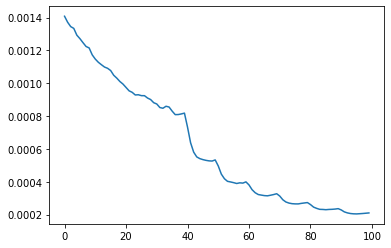

In [240]:
plt.plot(history.history["loss"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


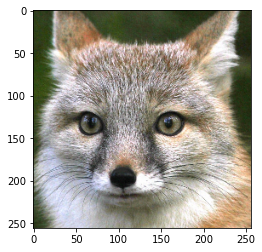

In [241]:
plt.imshow(save_result_fourier.images[-1])

In [245]:
# Added trainable Fourier Feature(2100 more parameter)
PSNR(Original, predicted)

36.94325448439011

In [146]:
# Added Fourier Feature(2100 more parameter)
PSNR(Original, predicted)

37.7788249321726

In [292]:
import imageio
images_siren = np.stack(save_result_siren.images, axis=0)
images_param = np.stack(save_result_param.images, axis=0)
images_gt = np.tile(np.expand_dims(Image, axis=0), (200, 1, 1, 1))
images = np.concatenate([images_siren, images_param, images_gt], axis=-2)   
images = (255*np.clip(images,0,1)).astype(np.uint8)
f = os.path.join('training_convergence.mp4')
imageio.mimwrite(f, images, fps=20)

In [136]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [310]:
# siren psnr
print(f"SIREN PSNR : {PSNR(images_siren[-1], images_gt[-1])}")

# param psnr
print(f"Param PSNR : {PSNR(images_param[-1], images_gt[-1])}")

SIREN PSNR : 28.603850243543206
Param PSNR : 32.98273442865603


In [242]:
predicted = model.predict(tf.data.Dataset.from_tensor_slices(Coordinates).batch(2048))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


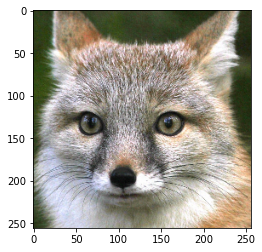

In [243]:
predicted = predicted.reshape(Image.shape)
plt.imshow(predicted)

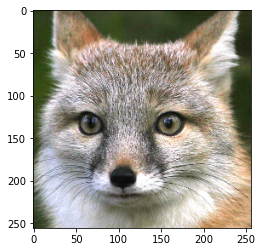

In [244]:
Original = RGB_values.reshape(Image.shape)
plt.imshow(Original)

In [140]:
# With Sine
PSNR(Original, predicted)

33.613613360357526

In [778]:
# With Parametric Sine
PSNR(Original, predicted)

32.36982078287086

In [795]:
# With Parametric Cosine
PSNR(Original, predicted)

32.945628879948686

In [97]:
# With Parametric Cosine and Sine
PSNR(Original, predicted)

33.26840663222405

In [208]:
# With Sine  with one additional layer
PSNR(Original, predicted)

34.588683116245555

In [190]:
# With Parametric Sine and Cosine with one additional layer
PSNR(Original, predicted)

35.39838301950507

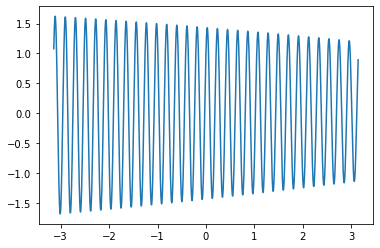

In [321]:
paraIdx = 27
n_param = 7

weight = model.get_weights()
parameters = weight[paraIdx : paraIdx + n_param]

n = np.linspace(-1*math.pi, 1*math.pi, 10000)
active_plot = parameters[0] * n + \
              parameters[1] * np.sin(parameters[2] * 30 * n + parameters[3]) + \
              parameters[4] * np.cos(parameters[5] * 30 * n + parameters[6])
plt.plot( n, active_plot )

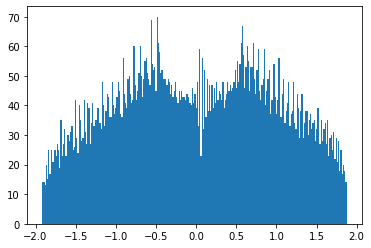

In [318]:
_ = plt.hist(active_plot, 250)

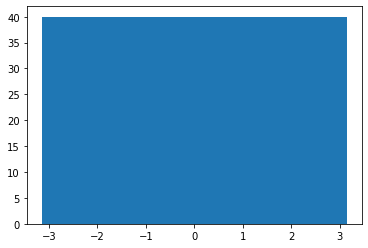

In [314]:
_ = plt.hist(n, 250)